We really care (and want to check) that honest, protocol-following validators, reap the highest (in-protocol) rewards. We'll get a feel for what this means here by pitting different validator behaviours against each other.

To introduce a bit of terminology, we are creating an _agent-based model_ here. We do not explicitly code a scenario that agents follow, but program simple update and interaction rules, let them unfold for a while, and then look at the tape to infer conclusions.

We'll distinguish between _strategies_ and _behaviours_. A validator can do several things: attest, propose, or do nothing. We'll call _strategies_ instantiations of these particular actions. For instance, a validator may employ the strategy of always attesting correctly, or flipping a coin and half the time attesting correctly, half the time not attesting at all (a pretty dumb strategy if you ask me).

We use the word _behaviour_ to describe the general articulation of these strategies: what to play and _when_. We explored in the [main notebook](br2050.html) the behaviour of the [ASAP validator](https://github.com/barnabemonnot/beaconrunner/blob/master/beaconrunner/validators/ASAPValidator.py), who does something as early as possible according to the specs (at the beginning of the slot for a block proposal; a third of a slot, i.e., 4 seconds in _or_ whenever the block for that slot is received for an attestation).

In this notebook, we'll look at a different behaviour too: the [Prudent validator](https://github.com/barnabemonnot/beaconrunner/blob/master/beaconrunner/validators/PrudentValidator.py). Although validators are expected to propose their block as early as possible, network delays could prevent attesters from receiving the block before a third of the slot has elapsed. ASAP validators would attest anyways, at the risk of voting on the wrong head, before receiving the block for that slot. Prudent validators hedge their bets a bit:

- If Prudent validators receive the block for their attesting slot, they publish their attestation with the head set to that block.
- If more than 8 seconds have elapsed into the slot, and they still haven't received a block, they attest for the head they know about.

In other words, although prudent validators are willing to wait to see if the block will turn up, there is a limit to how long they will wait: they need to communicate their attestations in a timely manner after all! They only differ from ASAPs by how long they are willing to wait.

### Rewards under consideration

To see how this behaviour impacts the payoff received by ASAP and prudent validators, let's dive into the rewards and penalties schedule for attesters (we won't look at rewards from block proposing here). Note first the following two things:

- Validators receive a bonus for attesting on the correct head. Attesting too early means possibly losing out on this bonus if the head specified in the attestation is incorrect.
- Validators receive a bonus for early inclusion of their attestation in a block. This means that they should attest relatively soon, and cannot wait forever to see if a missing block will turn up.

You can see [here in the specs](https://github.com/ethereum/eth2.0-specs/blob/579da6d2dc734b269dbf67aa1004b54bb9449784/specs/phase0/beacon-chain.md#get_attestation_deltas) how rewards and penalties are computed at the end of each epoch. Let's unpack the computations below.

### Attester rewards in eth2

A _base reward_ $\texttt{BR}$ is computed that depends only on the validator's effective balance (maximum 32 ETH) and the current total active balance (the total effective balance of _all_ active validators). Letting $i$ denote our validator,

$$ \texttt{BR[i]} = \texttt{balance[i]} \cdot \frac{\texttt{BRF}}{\sqrt{\texttt{total\_balance}} \cdot \texttt{BRPE}} $$

$\texttt{BRPE}$ stands for _base rewards per epoch_. A validator can be rewarded for

1. Attesting to the correct source, yielding $\texttt{BR[i]}$.
2. Attesting to the correct target, yielding $\texttt{BR[i]}$.
3. Attesting to the correct head, yielding $\texttt{BR[i]}$.
4. Early inclusion, yielding at most $\texttt{BR[i]} \Big( 1 - \frac{1}{\texttt{PRQ}} \Big)$ with $\texttt{PRQ}$ the _proposer reward quotient_.

These four items are why $\texttt{BRPE}$ is set to 4 (at least in phase 0). $\texttt{BRF}$, the _base reward factor_, is a scaling constant currently set at $2^6 = 64$.

For each of the first three items, we scale the base reward by the fraction of the active stake who correctly attested for the item. If $\rho_s$ is the fraction of the stake who attested correctly for the source, then a validator $i$ with a correct source receives $\rho_s \cdot \texttt{BR[i]}$. However, failure to attest or attesting for an incorrect source, target or head incurs the full $\texttt{BR[i]}$ as penalty.

Now, let's dig deeper into item 4, early inclusion. Attestations may be included at least one slot after the slot they are attesting for, called the _committee slot_. If they are included in the block immediately following their committee slot, they receive the full base reward, minus the _proposer reward_, endowed to the block producer (see table below). If they are included in the block two slots after their committee slot, they receive half. Three blocks later, a third, etc. Attestations must be included at the latest one full epoch after their committee slot. This means the smallest inclusion reward is 1/32 of the base reward (assuming `SLOTS_PER_EPOCH` is equal to 32).

These are the attester rewards in the best of times. Note however, that the penalties are not symmetric. Whenever a validator fails to attest for one of the first three items, or attests incorrectly, the penalty is equal to the whole base reward. No discount!

What about the worst of times? From the perspective of rewards and penalities, this happens when the chain is not finalising epochs anymore (a situation we explored in a [different notebook](br2049.html)). In this case, we want to "leak" the stake of inactive validators, who are preventing finalisation. A [recent modification](https://github.com/ethereum/eth2.0-specs/pull/1830) ensures that validators who perform optimally (i.e., attest correctly to all three items _and_ included in the block immediately following their committee slot) do not suffer any losses. Meanwhile, validators who are not attesting for the correct target (a key ingredient for finalisation) suffer increasingly painful consequences, as the _finality delay_ (the gap between the current epoch and the last finalised epoch) grows.

This is all synthesised in the following table. "IL" items refer to "Inactivity Leak": the rewards and penalties during these worst of times.

![](img/rewardsv1.png)

Let's explore a few examples. We note at the end of the formula whether the result is positive (the validator makes a profit) or negative (the validator makes a loss).

- A validator who gets everything correct, and whose attestations are included 2 slots after their committee slot, while the chain is finalising, reaps:

$$ \Big( \rho_s + \rho_t + \rho_h + \frac{1}{2} (1 - \frac{1}{\texttt{PRQ}}) \Big) \texttt{BR[i]} > 0 $$

- A validator who gets everything correct, and whose attestations are included 2 slots after their committee slot, while the chain is _not finalising_, reaps:

$$ \Big(3 + \frac{1}{2} (1 - \frac{1}{\texttt{PRQ}}) - \texttt{BRPE} + \frac{1}{\texttt{PRQ}} \Big) \texttt{BR[i]} = \Big(-\frac{1}{2} + \frac{1}{2\texttt{PRQ}} \Big) \texttt{BR[i]} < 0 $$

- A validator who gets everything correct _except the target_, and whose attestations are included 2 slots after their committee slot, while the chain is _not finalising_ with finality delay $f$, reaps:

$$ \Big(1 - 1 + 1 + \frac{1}{2} (1 - \frac{1}{\texttt{PRQ}}) - \texttt{BRPE} + \frac{1}{\texttt{PRQ}} \Big) \texttt{BR[i]} - \texttt{balance[i]} \cdot \frac{f}{\texttt{IPQ}} = \Big(-\frac{5}{2} + \frac{1}{2\texttt{PRQ}} \Big) \texttt{BR[i]} - \texttt{balance[i]} \cdot \frac{f}{\texttt{IPQ}} < 0 $$

### Some hypotheses before simulating

In a network with perfect (or close to perfect) latency and honest proposers, we don't expect ASAP and prudent validator earnings to differ significantly. But under real-world conditions, the behaviour of prudent validators appears more _robust_ than that of ASAP validators. By robust, we mean that prudent validators perform better under slight variations of the parameters, e.g., the average network latency.

When network delays are high or block proposers are lazy (meaning they don't propagate their blocks in time, perhaps because they are being prudent in order to collect more incoming attestations), prudent validators stand to reap the "correct head" reward more often. On the other hand, when network delays are really, really high, perhaps proposing ASAP is a better strategy, as it ensures at least _something_ goes through, even if it's possibly incorrect.

## _"Two nodes enter! One node leaves!"_

Let's pit `PrudentValidator`s against `ASAP`s and observe the result. In this simulation, we let `SLOTS_PER_EPOCH` equal 4 and simulate a small number of validators. Runs are now random: sometimes the network updates, sometimes it doesn't. We'll set it up later so that on average messages propagate one step further on the network every 4 seconds.

We first load all the necessary packages. The remainder will look a lot like what we did in the [main notebook](br2050.html), check it out for more background!

In [1]:
import importlib
import os
import types
from eth2spec.config.config_util import prepare_config
from eth2spec.utils.ssz.ssz_impl import hash_tree_root

In [2]:
import os, sys
sys.path.insert(1, os.path.realpath(os.path.pardir) + "/notebooks/thunderdome")

import beaconrunner as br

In [3]:
prepare_config(".", "fast.yaml")

.
present_dir fast.yaml


In [4]:
br.reload_package(br)

We then create our _observers_, to allow us to record interesting metrics at each simulation step.

In [5]:
def current_slot(params, step, sL, s, _input):
    return ("current_slot", s["network"].validators[0].data.slot)

def average_balance_prudent(params, step, sL, s, _input):
    validators = s["network"].validators
    validator = validators[0]
    head = br.specs.get_head(validator.store)
    current_state = validator.store.block_states[head]
    current_epoch = br.specs.get_current_epoch(current_state)
    prudent_indices = [i for i, v in enumerate(validators) if v.validator_behaviour == "prudent"]
    prudent_balances = [b for i, b in enumerate(current_state.balances) if i in prudent_indices]
    return ("average_balance_prudent", br.utils.eth2.gwei_to_eth(sum(prudent_balances) / float(len(prudent_indices))))

def average_balance_asap(params, step, sL, s, _input):
    validators = s["network"].validators
    validator = validators[0]
    head = br.specs.get_head(validator.store)
    current_state = validator.store.block_states[head]
    current_epoch = br.specs.get_current_epoch(current_state)
    asap_indices = [i for i, v in enumerate(validators) if v.validator_behaviour == "asap"]
    asap_balances = [b for i, b in enumerate(current_state.balances) if i in asap_indices]
    return ("average_balance_asap", br.utils.eth2.gwei_to_eth(sum(asap_balances) / float(len(asap_indices))))

observers = {
    "current_slot": current_slot,
    "average_balance_prudent": average_balance_prudent,
    "average_balance_asap": average_balance_asap,
}

And define a "main" function -- in this case, `simulate_thunderdome` -- to run the simulation. The function returns a `pandas` dataframe containing the metrics recorded throughout the run.

In [6]:
from random import sample
from beaconrunner.validators.ASAPValidator import ASAPValidator
from beaconrunner.validators.PrudentValidator import PrudentValidator

def simulate_once(network_sets, num_run, num_validators, network_update_rate):
    # Half our validators are prudent, the others are ASAPs
    num_prudent = int(num_validators / 2)

    # We sample the position on the p2p network of prudent validators randomly
    prudentset = set(sample(range(num_validators), num_prudent))

    validators = []

    # Initiate validators
    for i in range(num_validators):
        if i in prudentset:
            new_validator = PrudentValidator(i)
        else:
            new_validator = ASAPValidator(i)
        validators.append(new_validator)
    
    # Create a genesis state
    genesis_state = br.simulator.get_genesis_state(validators)
    
    # Validators load the state
    [v.load_state(genesis_state.copy()) for v in validators]

    br.simulator.skip_genesis_block(validators)

    network = br.network.Network(validators = validators, sets=network_sets)

    parameters = br.simulator.SimulationParameters({
        "num_epochs": 20,
        "num_run": num_run,
        "frequency": 1,
        "network_update_rate": network_update_rate,
    })

    return br.simulator.simulate(network, parameters, observers)

In [7]:
%%capture

import pandas as pd

num_validators = 12

# Create the network peers
set_a = br.network.NetworkSet(validators=list(range(0, int(num_validators * 2 / 3.0))))
set_b = br.network.NetworkSet(validators=list(range(int(num_validators / 2.0), num_validators)))
network_sets = list([set_a, set_b])

num_runs = 40
network_update_rate = 0.25

df = pd.concat([simulate_once(network_sets, num_run, num_validators, network_update_rate) for num_run in range(num_runs)])

To do a fair amount of runs (40) simulating a good number of epochs (20), we set a low number of validators (12). Since we are more interested in comparing individual rewards between ASAP and prudent validators rather than macro-properties or even scalability of the chain, this is not a bad thing to do (and it speeds things up quite a bit).

Note here that we keep the same network topology across all our runs. However, validator types are placed randomly over the network with each new run, with always 50% of them Prudent and the other 50% ASAPs.

Since we have 4 slots per epoch, and 20 epochs, let's read the average balances at slot 81, after the 20th epoch rewards and penalties were computed.

In [8]:
df[df.current_slot == 81][['average_balance_prudent', 'average_balance_asap']].describe()

,average_balance_prudent,average_balance_asap
count,40.000000,40.000000
mean,32.057495,32.053940
std,0.001533,0.002275
min,32.052082,32.047887
25%,32.056637,32.052751
50%,32.057755,32.054041
75%,32.058686,32.055261
max,32.060025,32.057624


It doesn't seem like a big difference, yet on average prudent validators have higher earnings than ASAPs! Taking into account the [standard error](https://en.wikipedia.org/wiki/Standard_error), the difference between the means appears to be [statistically significant](https://www.investopedia.com/terms/s/statistically_significant.asp), meaning that even though the difference is small, it's not likely to be due to chance alone (while we won't go down this path here, there are statistical tests we could use to test this more precisely if we wished). To see if our intuition is correct, let's chart the ensemble mean over the 40 runs too:

<AxesSubplot:xlabel='current_slot'>

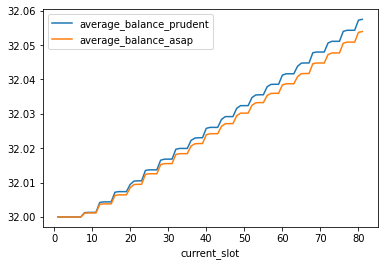

In [9]:
df.groupby(["current_slot"]).mean().reset_index().plot("current_slot", ["average_balance_prudent", "average_balance_asap"])

We see that, as we extend time, prudent validators definitely overtake ASAP validators. Even though 20 epochs is not that long -- at 12 seconds per slot, and 32 slots per epoch, 20 epochs is approximately 2 hours -- over time these differences accumulate.

## Try it out!

We specified the ASAP and prudent validators as two very simple Python classes. For instance, this is how the prudent validator's attestation behaviour is implemented:

```python
def attest(self, known_items) -> Optional[specs.Attestation]: 
    # Not the moment to attest
    if self.data.current_attest_slot != self.data.slot:
        return None

    time_in_slot = (self.store.time - self.store.genesis_time) % SECONDS_PER_SLOT

    # Too early in the slot / didn't receive block
    if not self.data.received_block and time_in_slot < 8:
        return None

    # Already attested for this slot
    if self.data.last_slot_attested == self.data.slot:
        return None

    # honest attest
    return honest_attest(self, known_items)
```

You too can specify your own agent behaviours following the simple validator API documented [here](https://barnabemonnot.com/beaconrunner/build/html/validatorlib.html), and have them attest and produce block in a simulated beacon chain environment following the steps outlined above.

Validators consume information contained in their `data` attribute. If you find yourself requiring more inputs from the simulation to program your validators, try opening an issue in the [Beacon Runner repo](https://github.com/barnabemonnot/beaconrunner).

## (Bonus) Better network

When latency decreases (faster propagation), are the effects as strong? We set the network update rate to 0.9, meaning that objects propagate on the network almost definitely each step.

In [10]:
%%capture

network_update_rate = 0.9

df = pd.concat([simulate_once(network_sets, num_run, num_validators, network_update_rate) for num_run in range(num_runs)])

<AxesSubplot:xlabel='current_slot'>

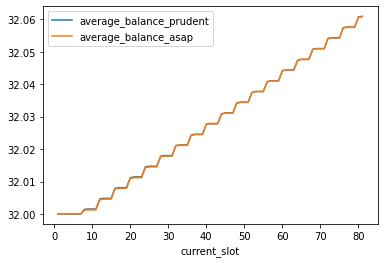

In [11]:
df.groupby(["current_slot"]).mean().reset_index().plot("current_slot", ["average_balance_prudent", "average_balance_asap"])

It is not as advantageous to be Prudent now, their payoffs are broadly similar to ASAPs. But it doesn't hurt either.